In [1]:
from tqdm.notebook import tqdm
import time
from lmfit.models import PowerLawModel,Pearson7Model
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

In [2]:
def OrganizeInputSI(SI_hs):
    SIraw = SI_hs.data
    XY = SIraw.shape[:2]
    disp = SI_hs.axes_manager[-1].scale
    offset = SI_hs.axes_manager[-1].offset
    
    EnergyAxes = np.linspace(0, SIraw.shape[-1]-1, SIraw.shape[-1]) * disp + offset
    return SIraw, XY, disp, EnergyAxes

In [9]:
def SI_FitPowerlaw_2R(SI,fs1,fe1,fs2,fe2):

    S=SI.sum(axis=(0,1)).data
    disp = SI.axes_manager[-1].scale
    offset = SI.axes_manager[-1].offset
    E=np.linspace(0, S.shape[-1]-1, S.shape[-1]) * disp + offset
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    
    mod =PowerLawModel()
    pars = mod.guess(s, x=e)
    out = mod.fit(s, pars, x=e)
    comps = out.eval(x=E[is1:ie2])
    reduced_chi_square=out.redchi

    fig=plt.figure(figsize=(20,5))
    
    ax=fig.add_subplot(131)
    plt.plot(E*1000,S,color='k',lw=3, label='Data')
    plt.plot(e*1000,s,marker='o',ms=8,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=14)
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    ax.set_ylabel(r'Intensity ($counts$)',fontsize=16)

    ax=fig.add_subplot(132)    
    plt.plot(E[is1:]*1000,S[is1:],color='k',lw=3, label='Data')
    plt.plot(E[is1:ie2]*1000,comps,color='b',ls='--',lw=3, label='Powerlaw Fit')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($meV$)',fontsize=16)
    plt.legend(frameon=False,fontsize=14)

    ax=fig.add_subplot(133)    
    plt.plot(E[is1:ie2]*1000,S[is1:ie2]-comps,color='g',lw=2, label='pearson_VII2 Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($meV$)',fontsize=16)
    plt.legend(frameon=False,fontsize=14)
    plt.axhline(0,color='grey',ls='--',lw=2)
    
    return reduced_chi_square

In [4]:
def Fitpearson_VII2R_lmfit(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    
    mod =Pearson7Model()
    pars = mod.guess(s, x=e)
    out = mod.fit(s, pars, x=e)
    comps = out.eval(x=E[is1:ie2])
    
    return E[is1:ie2],S[is1:ie2]-comps

In [5]:
def Fitpearson_VII2R_lmfit_plot(SI,fs1,fe1,fs2,fe2):
    
    S=SI.sum(axis=(0,1)).data
    disp = SI.axes_manager[-1].scale
    offset = SI.axes_manager[-1].offset
    E=np.linspace(0, S.shape[-1]-1, S.shape[-1]) * disp + offset
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,5))
    
    ax=fig.add_subplot(131)
    plt.plot(E*1000,S,color='k',lw=3, label='Data')
    plt.plot(e*1000,s,marker='o',ms=8,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=14)
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    ax.set_ylabel(r'Intensity ($counts$)',fontsize=16)
    mod =Pearson7Model()
    pars = mod.guess(s, x=e)
    out = mod.fit(s, pars, x=e)
    comps = out.eval(x=E[is1:ie2])
    reduced_chi_square=out.redchi

    ax=fig.add_subplot(132)    
    plt.plot(E[is1:]*1000,S[is1:],color='k',lw=3, label='Data')
    plt.plot(E[is1:ie2]*1000,comps,color='b',ls='--',lw=3, label='pearson_VII2 Fit')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($meV$)',fontsize=16)
    plt.legend(frameon=False,fontsize=14)
    
    ax=fig.add_subplot(133)    
    plt.plot(E[is1:ie2]*1000,S[is1:ie2]-comps,color='g',lw=2, label='pearson_VII2 Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($meV$)',fontsize=16)
    plt.legend(frameon=False,fontsize=14)
    plt.axhline(0,color='grey',ls='--',lw=2)
    
    
    return reduced_chi_square

## Here, I try to do the background fitting using different functions

In [20]:
SI = hs.load('SIdat.dm3').isig[-0.03:0.12]
SIraw, XY, disp, EnergyAxes=OrganizeInputSI(SI)
SIraw.shape

(146, 25, 150)

#### Powerlaw with two window can not work well

255597690.62142238

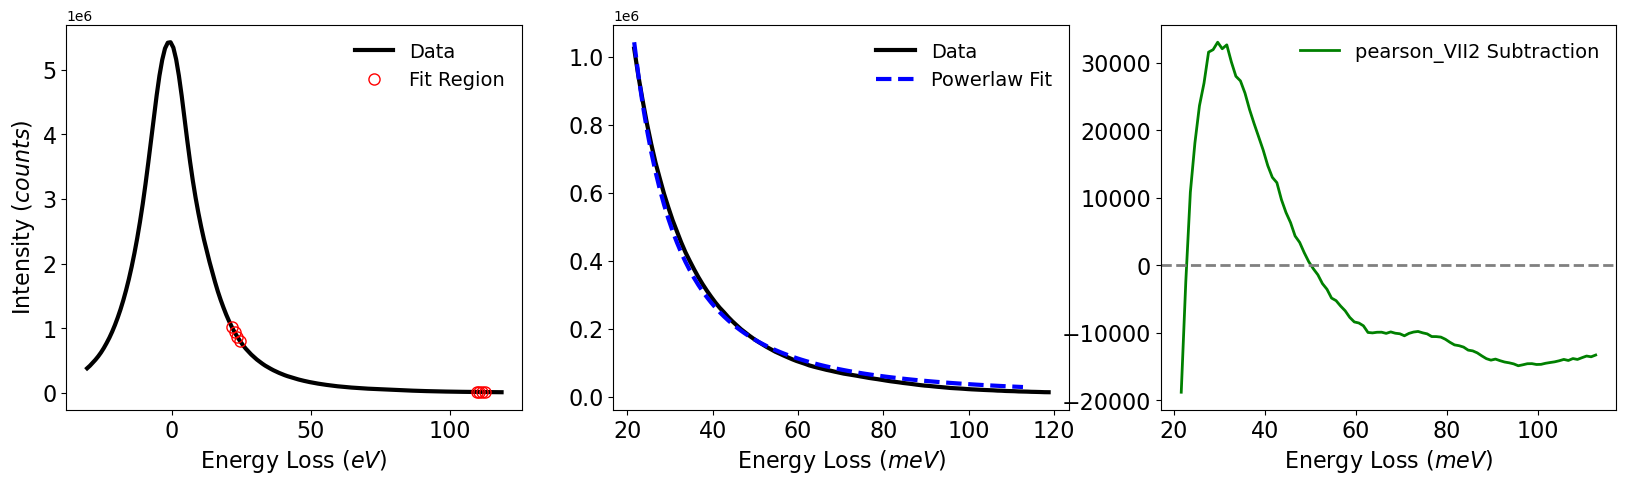

In [17]:
r1a = 0.022
r1b = 0.026
r2a = 0.11
r2b = 0.114

reduced_chi_square=SI_FitPowerlaw_2R(SI,r1a,r1b,r2a,r2b)
reduced_chi_square

#### pearson_VII2 with two window can give a good result

94982.43428990035

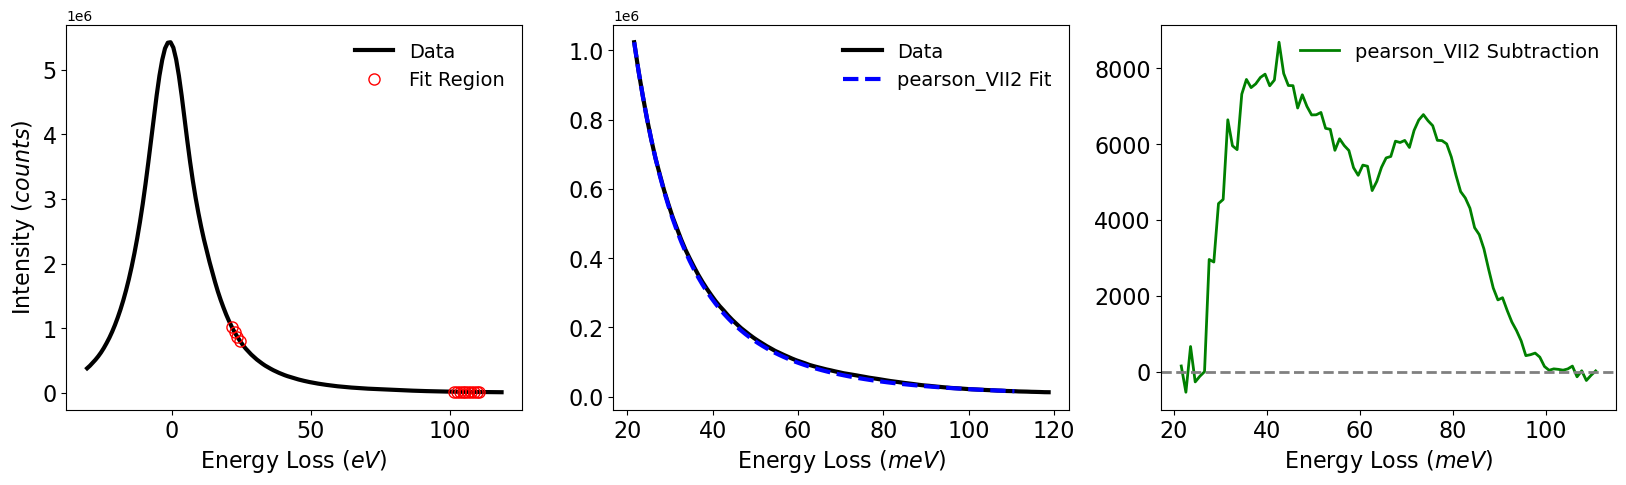

In [18]:
r1a = 0.022
r1b = 0.026
r2a = 0.102
r2b = 0.112

reduced_chi_square=Fitpearson_VII2R_lmfit_plot(SI,r1a,r1b,r2a,r2b)
reduced_chi_square

#### But when I try pixel-by-pixel fitting, there is a problem
#### it is time-consuming
#### for a 146x25 SI, it needs 1.5 hours for the total fitting

In [6]:
%%time

r1a = 0.022
r1b = 0.026
r2a = 0.102
r2b = 0.112

SI_edge = np.array([[Fitpearson_VII2R_lmfit(EnergyAxes,s,r1a,r1b,r2a,r2b) for s in row] for row in tqdm(SIraw)])
SI_edge.shape

  0%|          | 0/146 [00:00<?, ?it/s]

CPU times: total: 1h 35min 31s
Wall time: 1h 40min 20s


(146, 25, 2, 90)